# eQTL analysis

In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.stats import norm, uniform, percentileofscore
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import leidenalg
import glob
import sys
#import scvi
import gc
#import memento
import allel
from sklearn.decomposition import PCA
from sklearn.preprocessing import quantile_transform
import torch
import tensorqtl
import rpy2
from rpy2.robjects.packages import importr
qvalue = importr('qvalue')
from tensorqtl import pgen, cis, trans, post
import pyarrow as pa
import pyarrow.parquet as pq

## Background data and analyses (covariates etc.)

### Subset and format data for eQTL processing

In [38]:
# reading in the raw count data in backed mode
adata = sc.read_h5ad('../../test/test123/write/qc_020725_wctype_raw.h5ad', backed='r')

In [39]:
ethnicity_map = adata.obs[['FID','TID','Ethnicity']].drop_duplicates().reset_index().drop('index', axis=1)

In [40]:
# groups that libraries were processed in
batches = pd.read_csv("data/lib_groups.txt", sep="\t")

In [41]:
# write out samples for extracting genotype data
adata[adata.obs['COHORT']=="TOPMed"].obs[['TID']].drop_duplicates().to_csv("data/cameroon_samples.030425.csv", header=False, index=False)

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Note that two individuals, D1099 and D0019, were genotyped on the 5M chip. I'll be excluding them from eQTL analyses for the time being.

In [42]:
samps = pd.read_csv("data/cameroon_samples.030425.csv", names=['TID'])['TID']

In [43]:
# subset samples genotyped by TOPMed
adata = adata[adata.obs['TID'].isin(set(samps))].to_memory()

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [44]:
ctype_map = {"B cells": "B",
             "CD4+ T cells" : "CD4-T",
             "DN T cells" : "DNT",            
             "MAIT cells" : "MAIT",
             "Myeloid cells" : "M",
             "NK cells" : "NK",
             "Progenitor cells" : "Progenitor",
             "TRAV1-2- CD8+ T cells" : "CD8-T",
             "gd T cells" : "gdT"}

In [45]:
adata.obs[['Cluster_names','SCluster_names']] = adata.obs['FCluster_names'].str.split(':', expand=True)

In [46]:
# format cell names
adata.obs['cytopus_names'] = adata.obs['Cluster_names'].apply(lambda x: ctype_map[x])

In [55]:
# add batch
adata.obs['BATCH'] = adata.obs[['library']].reset_index().merge(batches, left_on="library", right_on="LIBRARY").set_index('index')['BATCH']

In [57]:
adata.write("data/qc_020725_wctype_raw.eqtl.h5ad")

### Compute genotype PCs

In [ ]:
samps = allel.read_vcf_headers("data/genotype/africa6k_public.topmed10.GOLD.chr22.maf05.biallelic.sc.cameroon.vcf.gz")[-1]

In [ ]:
# read in genotype data
vcf_unls = []

for i in range(1,23):
    
    vcf_f = "data/genotype/africa6k_public.topmed10.GOLD.chr{}.maf05.biallelic.sc.cameroon.vcf.gz".format(i)
    vcf = allel.GenotypeArray(allel.read_vcf(vcf_f)['calldata/GT']).to_n_alt()

    vcf_unls.append(vcf[allel.locate_unlinked(vcf),:])

In [ ]:
vcf_unl = np.concatenate(vcf_unls)

In [ ]:
sc_pca = allel.pca(vcf_unl)

In [ ]:
plt.plot(sc_pca[1].explained_variance_ratio_)

In [ ]:
sc_pca_df = pd.DataFrame(sc_pca[0],
                         columns=list(pd.Series(range(1,11)).apply(lambda x: "PC" + str(x))),
                         index=samps)

In [ ]:
# plotting by ethnicity
sc_pca_df.reset_index().rename(columns={'index':'TID'}).merge(ethnicity_map).plot.scatter('PC1','PC2',c='Ethnicity',cmap='viridis')

In [ ]:
sc_pca_df.to_csv("data/cameroon_samples.030425.pcs.csv")

### Normalize expression data and output mean expression values

In [15]:
# function borrowed from ivirshup at https://github.com/scverse/scanpy/issues/181
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [16]:
def format_gt_tqtl(vcf_f):

    # read in relevant genotype data                                                                                                                            
    vcf = allel.read_vcf(vcf_f)    
    
    genotype_df = pd.DataFrame(allel.GenotypeArray(vcf['calldata/GT']).to_n_alt(),
                               index = vcf['variants/ID'],
                               columns = vcf['samples'])

    variant_df = pd.DataFrame({'variant': vcf['variants/ID'],
                               'chrom': vcf['variants/CHROM'],
                               'pos': vcf['variants/POS'],
                               'index': [i for i in range(len(vcf['variants/CHROM']))]}) \
        .set_index('variant')
    
    return(genotype_df, variant_df)

In [18]:
def format_gex_tqtl(adata, ctype, cond, npcs):

    # subset to the cell types and conditions of interest
    adata_sub = adata[(adata.obs['cytopus_names']==ctype) & \
        (adata.obs['COND']==cond)].to_memory()

    # Normalizing to 10000 total counts
    sc.pp.normalize_total(adata_sub, target_sum=1e4)
    # Logarithmize the data
    sc.pp.log1p(adata_sub)

    nsamps = len(np.unique(adata_sub.obs['TID']))

    # find cells to test
    cell_means = grouped_obs_mean(adata_sub, 'TID')
    cell_n0 = cell_means.apply(lambda x: sum(x==0), axis=1)
    cell_median = cell_means.apply(lambda x: np.median(x), axis=1)
    cell_genes = list(cell_n0[(cell_n0 < 20) & (cell_median > 0.1)].index)
    cell_means = cell_means.loc[cell_genes,:]
    cell_norm = pd.DataFrame(list(cell_means.apply(lambda x: norm.ppf(x.rank(method="average")/(nsamps+1)), axis=1)),
                             columns=cell_means.columns,
                             index=cell_means.index)

    epca = PCA(n_components=npcs)
    epca.fit(cell_norm)
    epca_df = pd.DataFrame(epca.components_,
                       columns=epca.feature_names_in_,
                       index=list(pd.Series(range(npcs)).apply(lambda x: "ePC" + str(x)))) \
        .transpose().reset_index().rename(columns={'index':'TID'})

    return(adata_sub[:,cell_genes], cell_means, cell_norm, epca_df)

In [19]:
def format_covariates(adata, epca_df, gpca_df):

    batch = adata.obs[['TID','BATCH']] \
    .drop_duplicates().reset_index().drop('index', axis=1).set_index('TID')

    batch = pd.get_dummies(batch, drop_first=True) \
        .apply(lambda x: x.apply(lambda y: int(y)), axis=0).reset_index()

    batch = pd.pivot(batch.melt(id_vars='TID')
                     .drop_duplicates()
                     .groupby(['TID','variable'])
                     .sum().reset_index(),
                     index='TID', values='value', columns='variable').reset_index()
    
    cov = adata.obs[['TID','AGE','SEX']].drop_duplicates() \
        .merge(batch) \
        .merge(epca_df) \
        .merge(gpca_df) \
        .set_index('TID')

    cov['SEX'] = pd.get_dummies(cov['SEX'])['F'].apply(lambda x: int(x))

    return(cov)

### Test eQTL pipeline

In [20]:
adata = sc.read_h5ad("data/qc_020725_wctype_raw.eqtl.h5ad", backed='r')

In [21]:
gpca_df = pd.read_csv("data/cameroon_samples.030425.pcs.csv", index_col=0)

In [108]:
cond = "LPS"
ctype = "MAIT"
npcs = 22
vcf_f = "data/genotype/africa6k_public.topmed10.GOLD.chr1.maf05.biallelic.sc.cameroon.vcf.gz"

In [109]:
adata_eqtl, cell_means, phenotype_df, epca_df = format_gex_tqtl(adata, ctype, cond, npcs)

/tmp/ipykernel_17964/4215331215.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(group_key)
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [110]:
gene_bed = pd.read_csv("data/refdata-cellranger-arc-GRCh38-2020-A-2.0.0.genes.bed", sep="\t")
gene_bed = gene_bed.groupby('GENE').sample(1, random_state=1337).sort_values(['CHR','START'])

In [111]:
bed_sub = gene_bed[gene_bed['GENE'].apply(lambda x: x in set(phenotype_df.index))]

In [112]:
# create phenotype_pos_df object  
phenotype_pos_df = pd.concat([pd.DataFrame({'gene': bed_sub[bed_sub.STRAND=="+"]['GENE'],
                                            'chr': bed_sub[bed_sub.STRAND=="+"]['CHR'],
                                            'pos': bed_sub[bed_sub.STRAND=="+"]['START']}),
                              pd.DataFrame({'gene': bed_sub[bed_sub.STRAND=="-"]['GENE'],
                                            'chr': bed_sub[bed_sub.STRAND=="-"]['CHR'],
                                            'pos': bed_sub[bed_sub.STRAND=="-"]['STOP']})], axis=0) \
                     .set_index('gene').sort_values(['chr','pos'])

In [113]:
# filter phenotype_df to make it compativel with phenotype_pos_df                                                                                               
phenotype_df = phenotype_df.loc[phenotype_pos_df.index]

In [114]:
covariates_df = format_covariates(adata_eqtl, epca_df, gpca_df.iloc[:,0:4].reset_index().rename(columns={'index':'TID'}))
covariates_df = covariates_df.loc[phenotype_df.columns] # reshape covariates df   

/tmp/ipykernel_17964/2217046445.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['TID','variable'])


In [91]:
str(chroms.split(",")[0])

'1'

In [34]:
perm_l = []
permute_f = "output/pca_opt/tensorqtl_permute.{}.{}.csv".format(ctype.replace(' ','_'), cond)

In [115]:
i=1

chr = "chr" + str(i)

# if there are relevant phenotypes on the chromosome, analyze                                                                                               
if np.sum(phenotype_pos_df['chr'] == chr) > 0:

    print("running {}".format(chr))

    # read in genotype data for chromosome                                                                                                                  
    vcf_f = "data/genotype/africa6k_public.topmed10.GOLD.chr{}.maf05.biallelic.sc.cameroon.vcf.gz".format(i)
    genotype_df, variant_df = format_gt_tqtl(vcf_f)

    genotype_df = genotype_df[phenotype_df.columns]

    prefix_norm = "output/pca_opt/tensorqtl_nominal.{}.{}.{}".format(ctype.replace(' ','_'), cond, chr)

    # # perform nominal mapping                                                                                                                               
    # cis.map_nominal(genotype_df, variant_df,
    #                 phenotype_df.loc[phenotype_pos_df['chr'] == chr],
    #                 phenotype_pos_df.loc[phenotype_pos_df['chr'] == chr],
    #                 prefix_norm, covariates_df=covariates_df, window=1e5)

    # perform permutation mapping                                                                                                                           
    cis_df = cis.map_cis(genotype_df, variant_df,
                         phenotype_df.loc[phenotype_pos_df['chr'] == chr],
                         phenotype_pos_df.loc[phenotype_pos_df['chr'] == chr],
                         covariates_df=covariates_df, window=1e5, seed=4690)

    # append to list for further concatenation                                                                                                              
    perm_l.append(cis_df)

# if no relevant phenotypes, print message                                                                                                                  
else:
    print("No phenotypes on {}, skipping".format(chr))                                                                                               


running chr1
cis-QTL mapping: empirical p-values for phenotypes
  * 155 samples
  * 378 phenotypes
  * 56 covariates
  * 635661 variants
  * cis-window: ±100,000.0
  * using seed 4690
  * checking phenotypes: 378/378
    ** dropping 1 phenotypes without variants in cis-window
  * computing permutations
    processing phenotype 377/377
  Time elapsed: 1.22 min
done.


In [117]:
post.calculate_qvalues(cis_df, fdr=0.05, qvalue_lambda=0.85)

Computing q-values
  * Number of phenotypes tested: 377
  * Correlation between Beta-approximated and empirical p-values: 0.9999
  * Calculating q-values with lambda = 0.850
  * Proportion of significant phenotypes (1-pi0): 0.08
  * QTL phenotypes @ FDR 0.05: 2
  * min p-value threshold @ FDR 0.05: 0.000579263


/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/tensorqtl/post.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lb = lb[-1]
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/tensorqtl/post.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ub = ub[0]


In [119]:
cis_df.sort_values('qval')

,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold
phenotype_id,,,,,,,,,,,,,,,,,,
GAS5,481,1.032560,18.430655,78.510239,0.000003,chr1_173817798_T_C,-51084,-51084,59,67,0.216129,1.995983e-07,0.587287,0.104870,0.000100,0.000039,0.013448,0.000040
PHACTR4,513,1.023317,28.438354,80.581253,0.000007,chr1_28438040_C_CA,68458,68458,105,143,0.538710,7.815862e-07,-0.490969,0.092941,0.000200,0.000157,0.027156,0.000024
LYST,664,1.041572,64.179016,77.995918,0.000021,chr1_235856093_C_A,-27547,-27547,94,116,0.625806,2.057022e-06,-0.435903,0.086289,0.000600,0.001002,0.115770,0.000012
RABGAP1L,428,1.004211,16.746063,81.159164,0.000353,chr1_174178378_G_A,18968,18968,98,129,0.583871,9.300767e-05,-0.326369,0.080025,0.005799,0.005757,0.399157,0.000036
MTF2,470,1.065669,46.445904,77.486671,0.000156,chr1_93030006_TA_T,-49229,-49229,57,64,0.206452,2.299057e-05,0.614206,0.138044,0.003000,0.005073,0.399157,0.000020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SH2D2A,556,1.053847,80.564690,79.709702,0.046886,chr1_156846129_C_T,29267,29267,19,20,0.064516,2.827019e-02,0.524737,0.235641,0.975602,0.976646,0.913120,0.000011
TUT4,439,1.043284,36.440014,79.509232,0.129278,chr1_52575296_A_G,21809,21809,37,40,0.129032,9.364631e-02,-0.230288,0.136016,0.992701,0.992892,0.918452,0.000022
PSMA5,360,1.031850,27.085793,80.221756,0.209019,chr1_109480274_A_C,53826,53826,99,137,0.441935,1.669253e-01,-0.158152,0.113566,0.998100,0.998115,0.918452,0.000027


In [74]:
import seaborn as sns

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='chr1_39026790_C_T', ylabel='NDUFS5'>

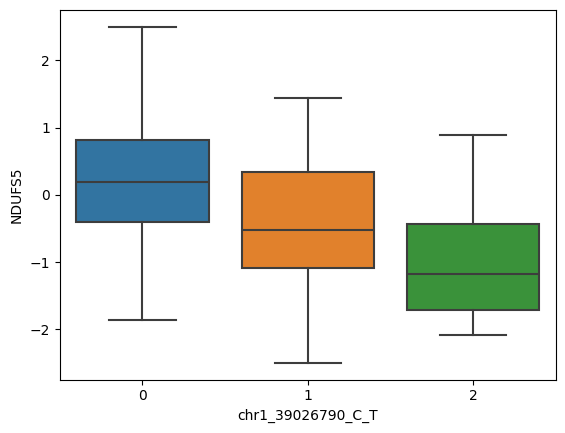

In [82]:
sns.boxplot(x=genotype_df.loc['chr1_39026790_C_T'], y=phenotype_df.loc['NDUFS5'])

### Get optimum number of expression PCs per condition and condition

In [2]:
from scipy.interpolate import interp1d
import os

In [3]:
ctypes = ["B","CD4-T","DNT","MAIT","M","NK","Progenitor","CD8-T","gdT"]
conds = ["CTL","IFN","LPS"]

/tmp/ipykernel_277950/3420022722.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


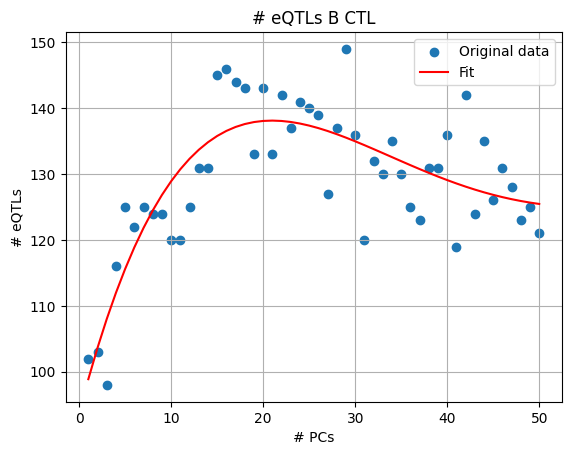

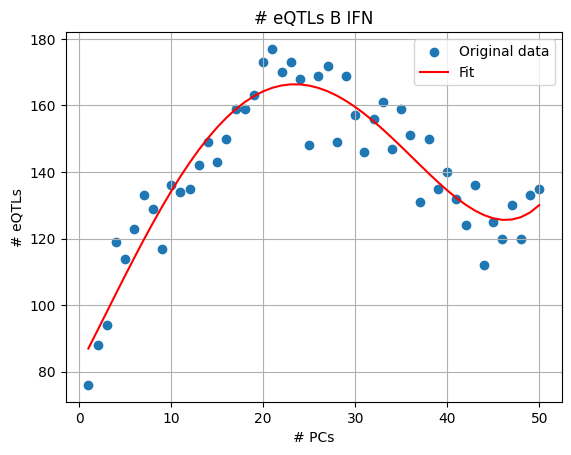

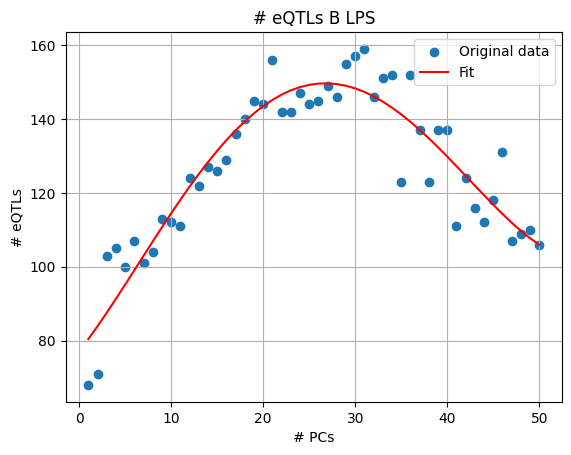

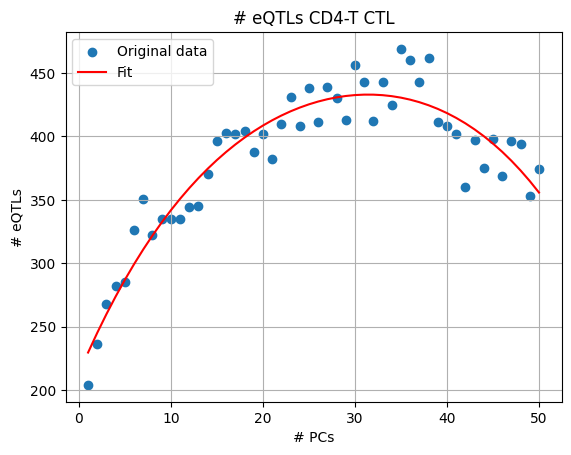

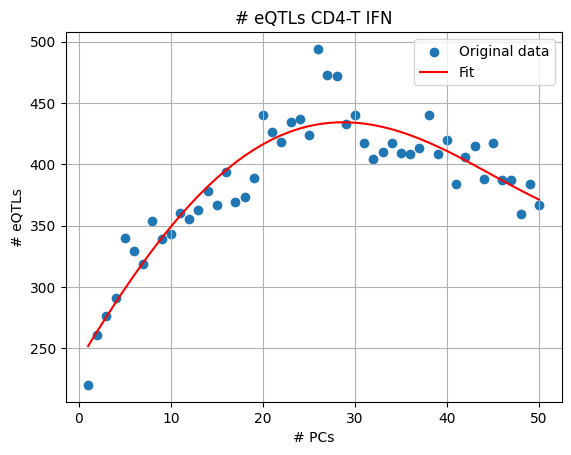

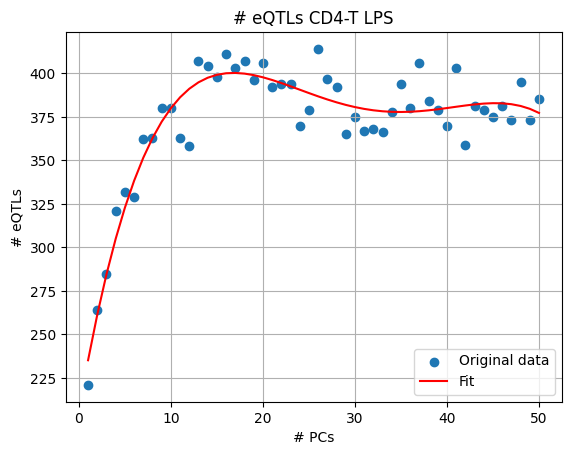

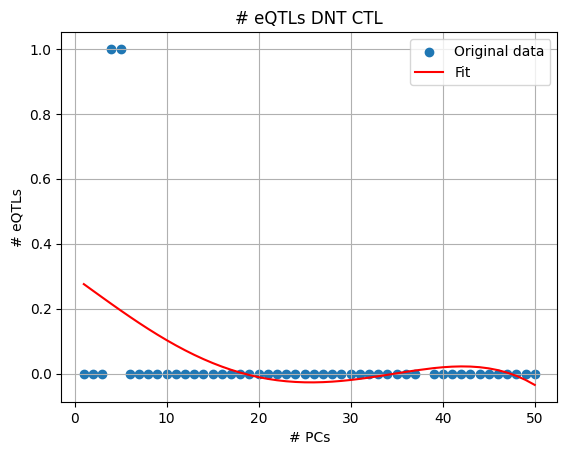

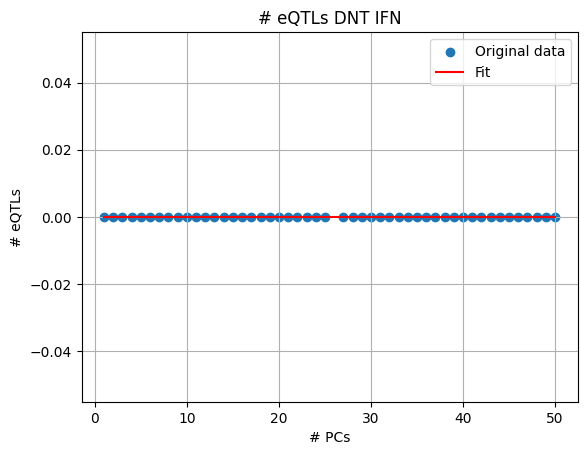

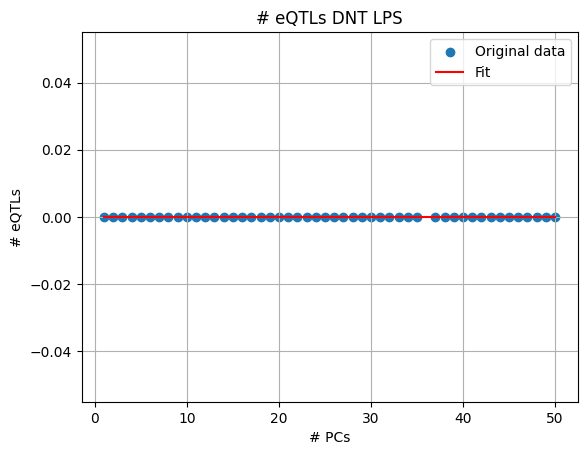

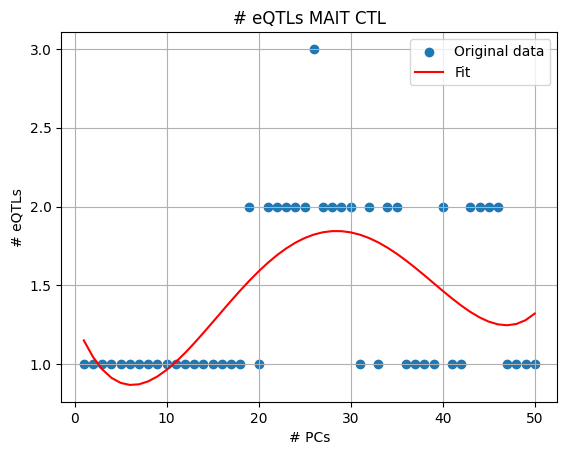

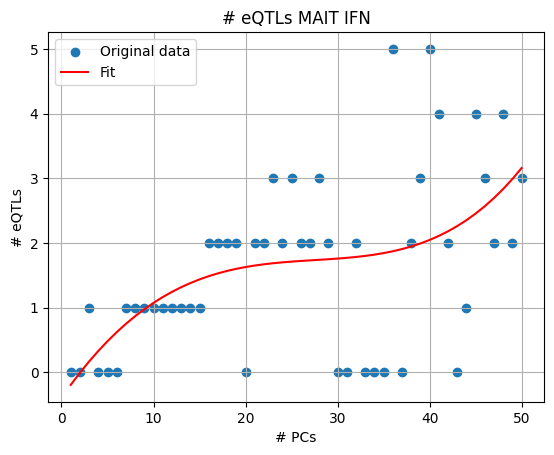

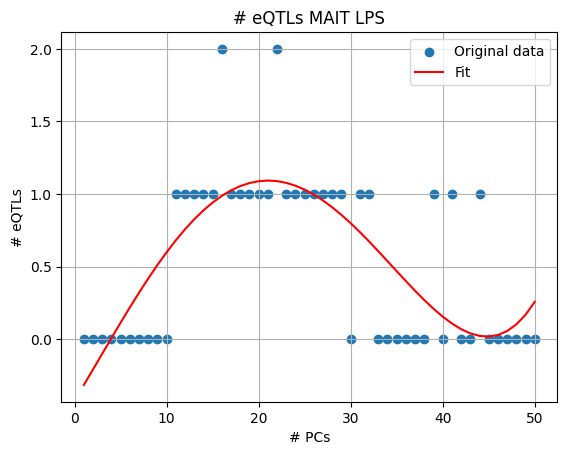

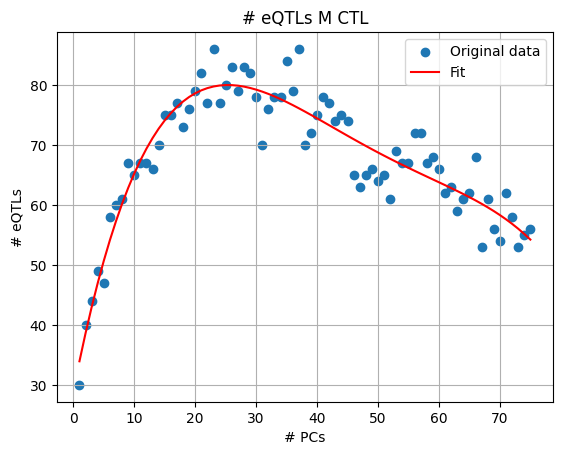

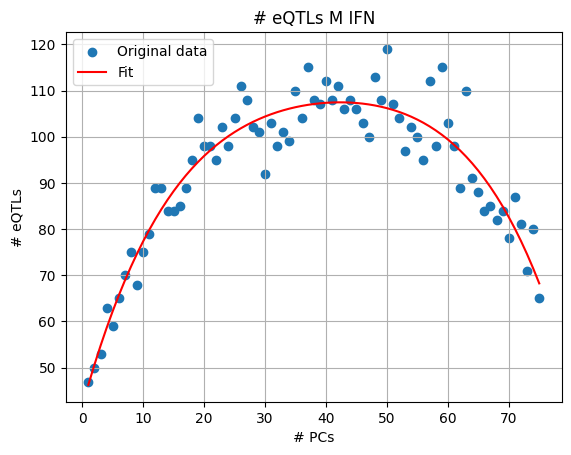

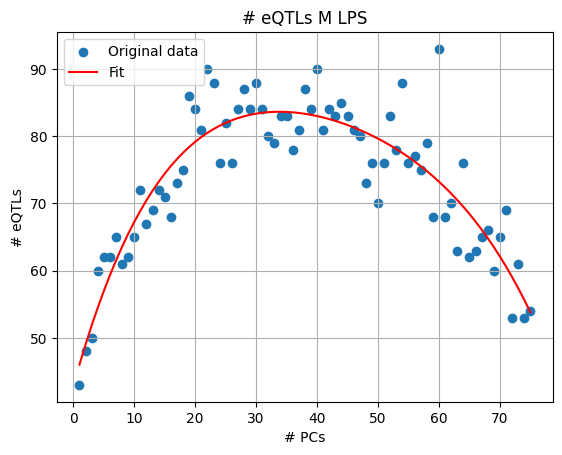

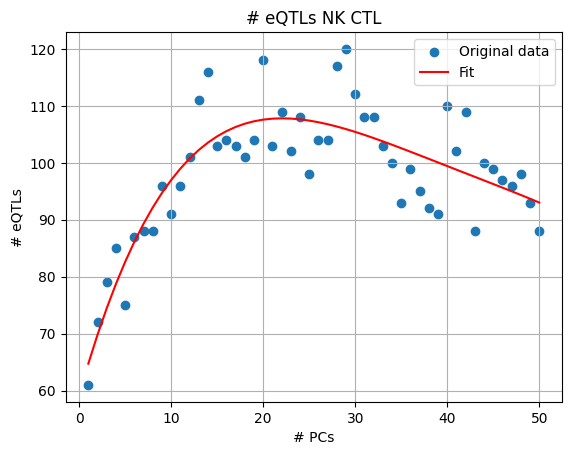

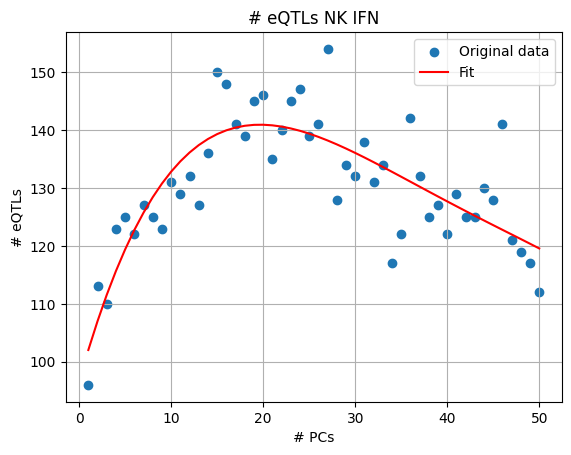

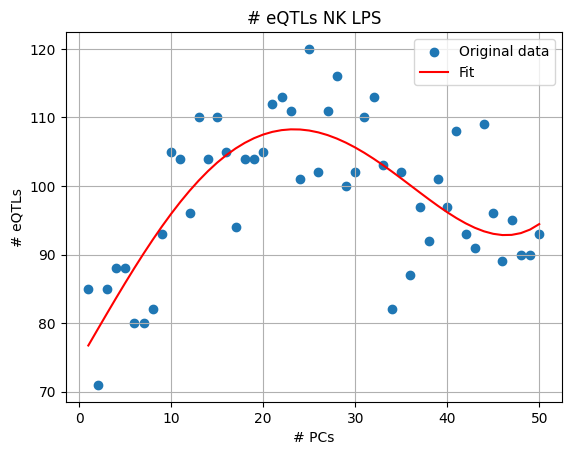

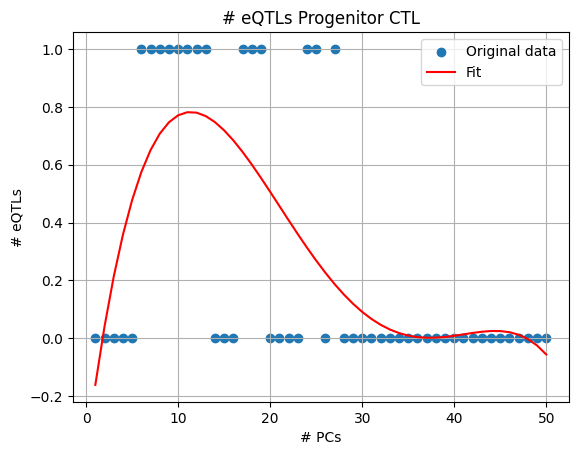

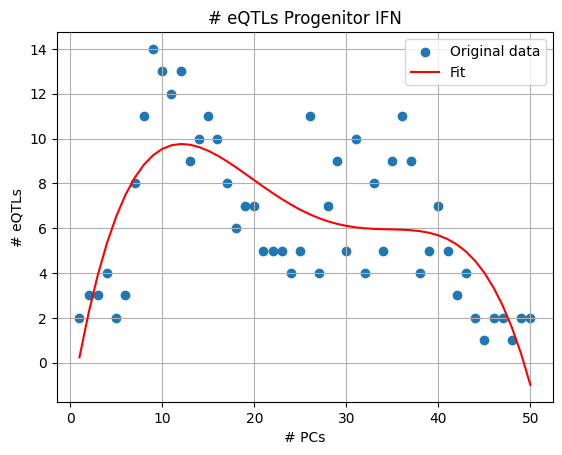

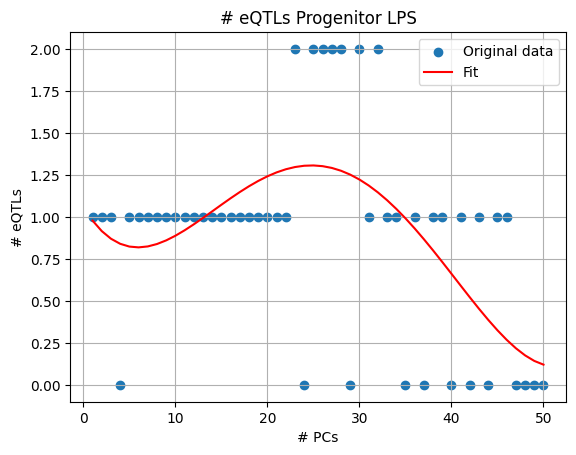

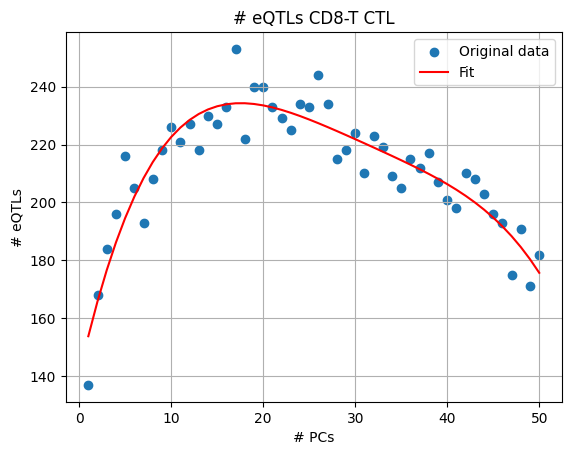

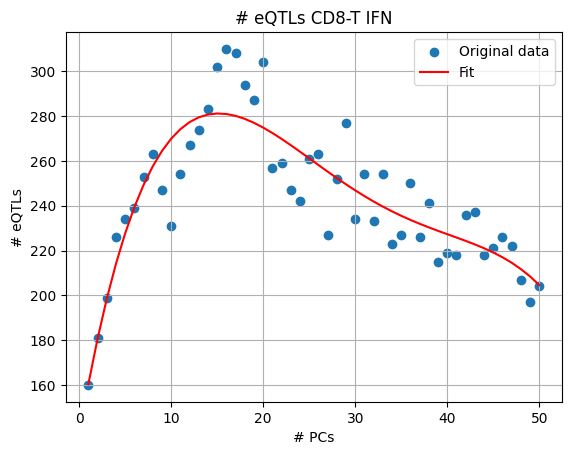

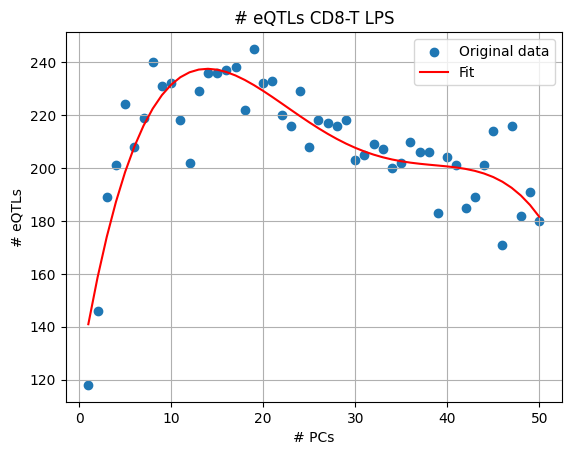

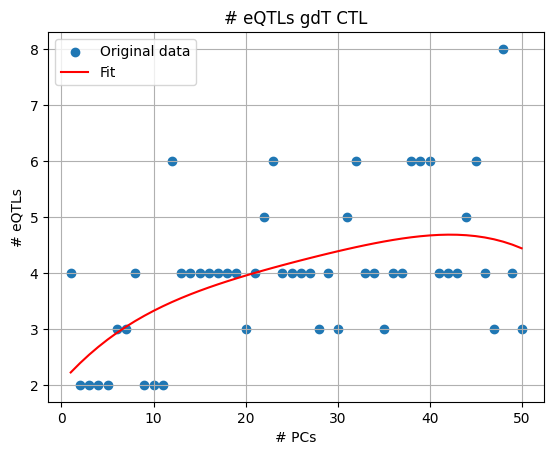

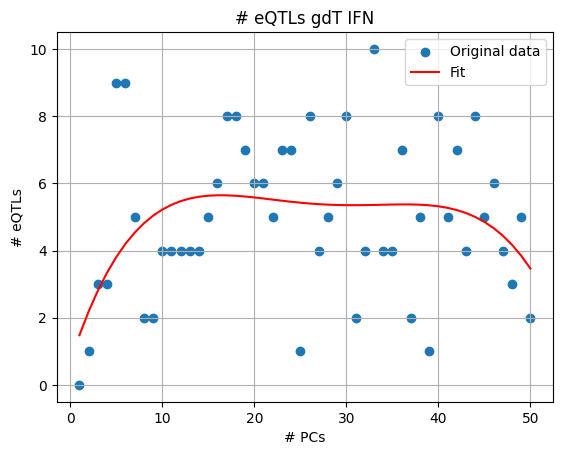

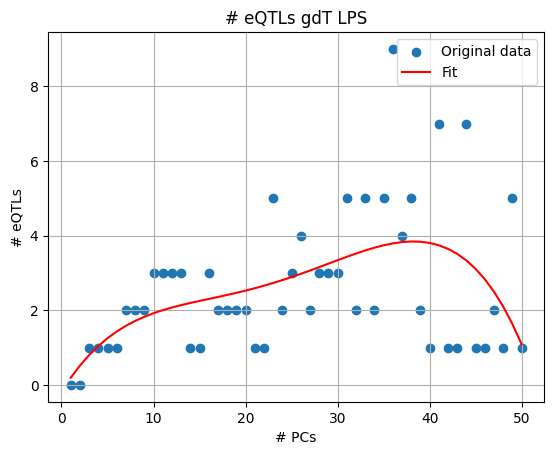

In [37]:
pc_opts = []
# get the number of PCs that maximizes discovered eQTLs
for ctype in ctypes:
    for cond in conds:
        eqtl_cnts = []
        for i in range(1,76):
        
            if os.path.exists("output/pca_opt/tensorqtl_permute.{}.{}.{}pcs.csv".format(ctype,cond,i)):
                eqtl = pd.read_csv("output/pca_opt/tensorqtl_permute.{}.{}.{}pcs.csv".format(ctype,cond,i))
                eqtl_cnts.append((i, np.sum(eqtl['qval'] < 0.05)))

        x = [i for i, _ in eqtl_cnts]
        y = [j for _, j in eqtl_cnts]
        coefficients = np.polyfit(x, y, 4)

        y_fit = np.polyval(coefficients, x)

        df_tmp = pd.DataFrame({'ctype': ctype, 'cond': cond, 'opt_pcs': x[np.argmax(y_fit)], 'n_eqtl': np.max(y)}, index=['0'])
        pc_opts.append(df_tmp)

        # plt.figure()
        # plt.scatter(x, y, label='Original data')
        # plt.plot(x, y_fit, label='Fit', color='red')
        # plt.xlabel('# PCs')
        # plt.ylabel('# eQTLs')
        # plt.legend()
        # plt.title('# eQTLs {} {}'.format(ctype,cond))
        # plt.grid(True)
        # plt.savefig("output/figures/eqtl_by_pc.{}.{}.png".format(ctype,cond))

pc_opt_df = pd.concat(pc_opts)

In [38]:
pc_opt_df.to_csv("data/opt_pcs.csv", index=False)

### Analyze eQTL results

#### Get all significant SNPs

In [38]:
ctypes = ["B","CD4-T","DNT","MAIT","M","NK","Progenitor","CD8-T","gdT"]
conds = ["CTL","IFN","LPS"]

for ctype in ctypes:
    for cond in conds:
        
        perm_file = glob.glob('output/eqtl_all/tensorqtl_permute.{}.{}.*pcs.csv'.format(ctype,cond))[0]
        eqtl_perm = pd.read_csv(perm_file)

        # check if there are any significant eGenes
        if np.sum(eqtl_perm['qval'] < 0.05) > 0:

            eqtl_sigs = []
    
            out_file = "output/eqtl_sig/tensorqtl_sig.{}.{}.tsv".format(ctype,cond)
            
            for i in range(1,23):
    
                nom_file = glob.glob('output/eqtl_all/tensorqtl_nominal.{}.{}.*.chr{}.cis_qtl_pairs.chr{}.parquet'.format(ctype,cond,i,i))[0]
                eqtl_nom = pd.read_parquet(nom_file, engine='pyarrow')
                
                eqtl_sig = eqtl_nom.merge(eqtl_perm[eqtl_perm['qval'] < 0.05][['phenotype_id','qval','pval_nominal_threshold']])
                eqtl_sig = eqtl_sig[eqtl_sig['pval_nominal'] < eqtl_sig['pval_nominal_threshold']]
    
                eqtl_sigs.append(eqtl_sig)
    
            pd.concat(eqtl_sigs).to_csv(out_file, sep="\t", index=False)

'IFN'

#### Summarize results

In [25]:
ctypes = ["B","CD4-T","DNT","MAIT","M","NK","Progenitor","CD8-T","gdT"]
conds = ["CTL","IFN","LPS"]

perm_results = []

for ctype in ctypes:
    for cond in conds:
        
        perm_file = glob.glob('output/eqtl_all/tensorqtl_permute.{}.{}.*pcs.csv'.format(ctype,cond))[0]
        eqtl_perm = pd.read_csv(perm_file)
        eqtl_sig = eqtl_perm[eqtl_perm['qval'] < 0.05]
        eqtl_sig['ctype'] = ctype
        eqtl_sig['cond'] = cond
        perm_results.append(eqtl_sig)


/tmp/ipykernel_117135/834105750.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eqtl_sig['ctype'] = ctype
/tmp/ipykernel_117135/834105750.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eqtl_sig['cond'] = cond
/tmp/ipykernel_117135/834105750.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [26]:
perm_sig = pd.concat(perm_results)

In [28]:
len(np.unique(perm_sig['phenotype_id']))

6912

In [50]:
gene_cond_counts = perm_sig.groupby(['phenotype_id','cond'])['variant_id'].count().reset_index()

In [43]:
max_indices = perm_sig.groupby('phenotype_id')['qval'].idxmin()

perm_sig_minq = perm_sig.loc[max_indices]

In [51]:
gene_cond_counts

,phenotype_id,cond,variant_id
0,A1BG,CTL,2
1,A1BG,IFN,2
2,A1BG,LPS,2
3,A2M,CTL,3
4,A2M,IFN,2
...,...,...,...
15558,ZYG11B,CTL,1
15559,ZYG11B,IFN,1
15560,ZYG11B,LPS,4
15561,ZYX,CTL,1


/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

(0.0, 1.0)

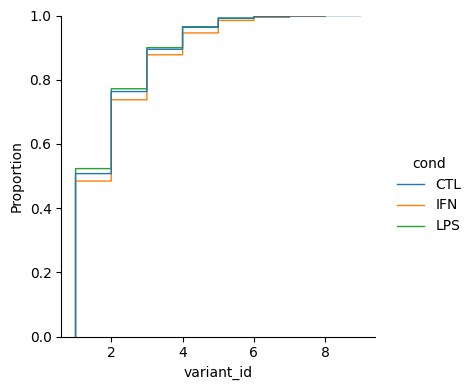

In [56]:
g = sns.displot(kind='ecdf', data=gene_cond_counts, x='variant_id', hue='cond', height=4, lw=1)
g.axes[0][0].set_ylim(0, 1)

In [62]:
ctype_cond_counts = perm_sig.groupby(['ctype','cond',])['variant_id'].count().reset_index()

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

<Axes: xlabel='ctype', ylabel='variant_id'>

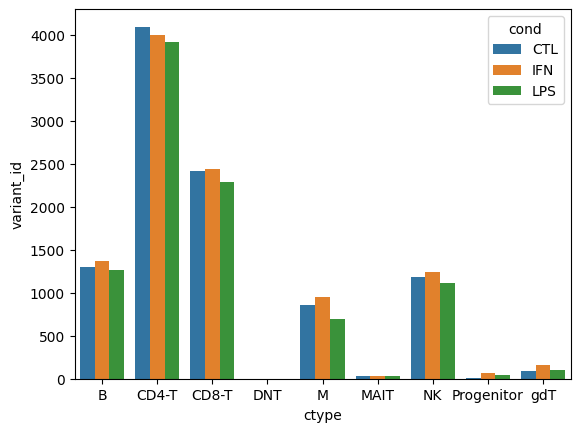

In [68]:
sns.barplot(ctype_cond_counts, x='ctype', y='variant_id', hue='cond')

(array([ 476.,  326.,  290.,  230.,  250.,  283.,  220.,  260.,  174.,
         216.,  226.,  178.,  213.,  197.,  176.,  226.,  207.,  184.,
         259.,  192.,  221.,  247.,  228.,  276.,  225.,  208.,  313.,
         268.,  272.,  279.,  308.,  342.,  280.,  381.,  309.,  324.,
         416.,  373.,  394.,  531.,  421.,  458.,  493.,  513.,  517.,
         640.,  653.,  820.,  917., 1945., 2413.,  779.,  722.,  649.,
         476.,  515.,  400.,  414.,  394.,  363.,  325.,  349.,  364.,
         341.,  272.,  326.,  293.,  300.,  252.,  256.,  267.,  199.,
         214.,  201.,  246.,  191.,  205.,  241.,  206.,  229.,  202.,
         175.,  177.,  209.,  193.,  213.,  212.,  206.,  149.,  139.,
         242.,  179.,  176.,  144.,  167.,  181.,  207.,  185.,  203.,
         207.]),
 array([-9.999200e+04, -9.799239e+04, -9.599278e+04, -9.399317e+04,
        -9.199356e+04, -8.999395e+04, -8.799434e+04, -8.599473e+04,
        -8.399512e+04, -8.199551e+04, -7.999590e+04, -7.799629e+04

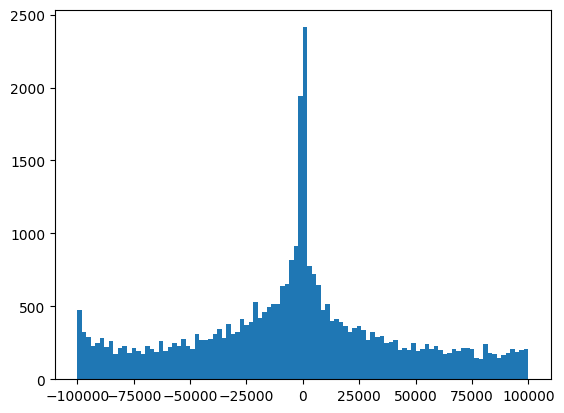

In [44]:
plt.hist(perm_sig_minq['start_distance'], bins=100)

In [70]:
from upsetplot import UpSet, from_indicators

In [69]:
upset = UpSet(data=adata_fail_up_df, intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(
    by="leiden_1_all", colors=colors_list, title="Failure to pass filter by cluster", elements=10
)

NameError: name 'UpSet' is not defined

(array([2508., 1310.,  726.,  352.,  201.,   51.,   15.,   14.]),
 array([1.   , 1.875, 2.75 , 3.625, 4.5  , 5.375, 6.25 , 7.125, 8.   ]),
 <BarContainer object of 8 artists>)

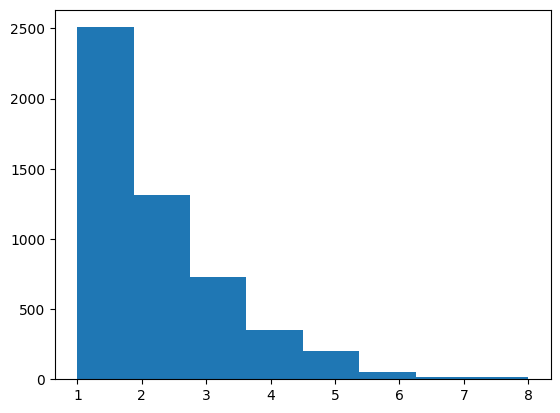

In [36]:
plt.hist(ifn_counts, bins=8)

In [ ]:
plt.hist(ctl_counts, bins=9)

#### Exploration

In [73]:
eqtl_nom = pd.read_parquet("output/eqtl_all/tensorqtl_nominal.MCD4-T.CTL.31.chr2.cis_qtl_pairs.chr2.parquet", engine='pyarrow')

In [68]:
eqtl_perm = pd.read_csv("output/eqtl_all/tensorqtl_permute.CD4-T.CTL.31pcs.csv")

In [74]:
eqtl_nom['nl10_pval'] = -np.log10(eqtl_nom['pval_nominal'])

In [75]:
eqtl_nom[['chr','pos','ref','alt']] = eqtl_nom['variant_id'].str.split('_', expand=True)

In [76]:
eqtl_nom['pos'] = pd.to_numeric(eqtl_nom['pos'])

In [25]:
eqtl_perm.sort_values('pval_beta').head(25)

,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold
2506,SNHG5,275,1.016282,19.040546,75.050660,1.560382e-26,chr6_85588345_A_G,-90587,-90587,73,86,0.731250,1.622174e-31,-1.182986,0.065847,0.0001,1.176863e-25,4.479927e-22,0.000522
2367,LINC00243,856,1.044812,41.529320,72.926125,9.242038e-24,chr6_30798988_C_G,-31671,-31671,85,104,0.325000,5.690239e-29,1.162784,0.070437,0.0001,4.132060e-23,7.653282e-20,0.000275
555,NCF2,617,1.022685,32.965950,74.681150,6.826535e-24,chr1_183589039_T_C,-1837,-1837,104,127,0.396875,1.746807e-28,-0.877721,0.054058,0.0001,7.196208e-23,7.653282e-20,0.000311
3305,TTC39B,935,1.077093,87.003610,69.638626,4.158862e-23,chr9_15304784_C_A,-2576,-2576,40,42,0.868750,2.002665e-29,-1.520865,0.090727,0.0001,9.286208e-23,7.653282e-20,0.000152
5284,ATP6V0C,307,1.012304,32.223670,76.302444,5.802772e-24,chr16_2506814_A_G,-7138,-7138,77,91,0.284375,5.399633e-28,0.903099,0.056565,0.0001,1.005247e-22,7.653282e-20,0.000302
3870,CD151,506,1.068171,58.081768,72.226616,1.583283e-20,chr11_833668_C_T,781,781,104,136,0.425000,3.271867e-25,0.933594,0.064530,0.0001,5.261937e-20,3.170245e-17,0.000219
4126,XRRA1,382,1.025172,25.755535,72.865530,6.783170e-21,chr11_74948257_A_T,-943,-943,59,68,0.212500,1.856096e-25,1.079058,0.073921,0.0001,5.829698e-20,3.170245e-17,0.000403
2641,AL078604.4,715,1.058885,37.293633,70.107620,3.154353e-20,chr6_159676759_G_A,14132,14132,85,104,0.675000,1.518912e-25,-1.022733,0.069842,0.0001,1.008882e-19,4.800595e-17,0.000327
6719,TTC28,303,1.016456,27.749680,74.947870,6.450948e-18,chr22_28587222_G_A,-92643,-92643,48,58,0.181250,3.214192e-21,1.043713,0.084030,0.0001,9.790909e-17,3.862521e-14,0.000358
4250,MRPL51,601,1.027122,67.011420,74.697920,4.049112e-18,chr12_6493256_C_T,-585,-585,120,156,0.512500,1.576155e-21,-0.756757,0.060176,0.0001,1.014673e-16,3.862521e-14,0.000157


/tmp/ipykernel_162659/59291262.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.sort(-np.log10(np.linspace(0, 1, eqtl_nom.shape[0]))), np.sort(eqtl_nom['nl10_pval']))


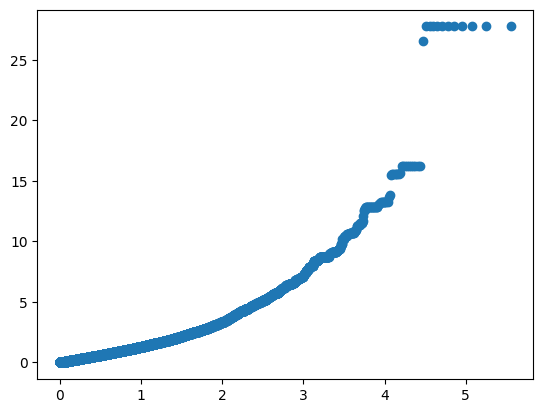

In [38]:
plt.scatter(np.sort(-np.log10(np.linspace(0, 1, eqtl_nom.shape[0]))), np.sort(eqtl_nom['nl10_pval']))

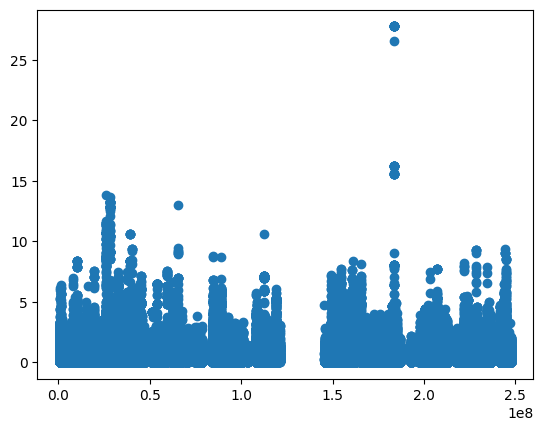

In [39]:
plt.scatter(eqtl_nom['pos'], eqtl_nom['nl10_pval'])

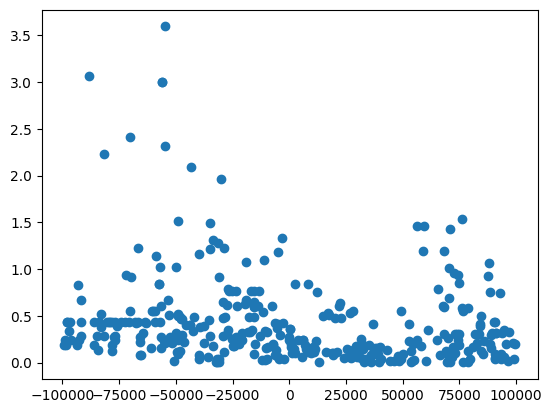

In [77]:
plt.scatter(eqtl_nom[eqtl_nom['phenotype_id']=="STAT1"]['start_distance'], eqtl_nom[eqtl_nom['phenotype_id']=="STAT1"]['nl10_pval'])

### reQTLs

Bruna Balliu suggested I run reQTLs on SNPs that are significant eQTLs to reduce multiple testing burden. The pipeline should be similar except that the mean expression will be replaced with the expression difference. Unsure if I should quantile normalize, and if so before or after subtracting.

#### Functions adapted from run_tensorqtl.reqtl.py

In [11]:
# function borrowed from ivirshup at https://github.com/scverse/scanpy/issues/181                                                                               
# calculates the mean value for a group in an adata object                                                                                                      
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

# format genotype data                                                                                                                                          
def format_gt_tqtl(vcf_f):

    # read in relevant genotype data                                                                                                                           $
    vcf = allel.read_vcf(vcf_f)

    genotype_df = pd.DataFrame(allel.GenotypeArray(vcf['calldata/GT']).to_n_alt(),
                               index = vcf['variants/ID'],
                               columns = vcf['samples'])

    variant_df = pd.DataFrame({'variant': vcf['variants/ID'],
                               'chrom': vcf['variants/CHROM'],
                               'pos': vcf['variants/POS'],
                               'index': [i for i in range(len(vcf['variants/CHROM']))]}) \
        .set_index('variant')

    return(genotype_df, variant_df)

# formate genotype data and calculate expression PCs                                                                                                            
def format_gex_tqtl(adata, ctype, cond, npcs):

    # subset to the cell types and conditions of interest                                                                                                       
    adata_sub = adata[(adata.obs['cytopus_names']==ctype) & \
        (adata.obs['COND'].isin(conds))].to_memory()

    # Normalizing to 10000 total counts                                                                                                                         
    sc.pp.normalize_total(adata_sub, target_sum=1e4)
    # Logarithmize the data                                                                                                                                     
    sc.pp.log1p(adata_sub)

    nsamps = len(np.unique(adata_sub.obs['TID']))

    # find cells to test                                                                                                                                        
    cell_means = grouped_obs_mean(adata_sub, 'TID')
    cell_n0 = cell_means.apply(lambda x: sum(x==0), axis=1)
    cell_median = cell_means.apply(lambda x: np.median(x), axis=1)
    cell_genes = list(cell_n0[(cell_n0 < 20) & (cell_median > 0.1)].index)
    cell_means = cell_means.loc[cell_genes,:]
    cell_norm = pd.DataFrame(list(cell_means.apply(lambda x: norm.ppf(x.rank(method="average")/(nsamps+1)), axis=1)),
                             columns=cell_means.columns,
                             index=cell_means.index)

    epca = PCA(n_components=npcs)
    epca.fit(cell_norm)
    epca_df = pd.DataFrame(epca.components_,
                       columns=epca.feature_names_in_,
                       index=list(pd.Series(range(npcs)).apply(lambda x: "ePC" + str(x)))) \
        .transpose().reset_index().rename(columns={'index':'TID'})

    return(adata_sub[:,cell_genes], cell_means, cell_norm, epca_df)

# formate covariates                                                                                                                                            
def format_covariates(adata, epca_df, gpca_df):

    batch = adata.obs[['TID','BATCH']] \
    .drop_duplicates().reset_index().drop('index', axis=1).set_index('TID')

    batch = pd.get_dummies(batch, drop_first=True) \
        .apply(lambda x: x.apply(lambda y: int(y)), axis=0).reset_index()

    batch = pd.pivot(batch.melt(id_vars='TID')
                     .drop_duplicates()
                     .groupby(['TID','variable'])
                     .sum().reset_index(),
                     index='TID', values='value', columns='variable').reset_index()

    cov = adata.obs[['TID','AGE','SEX']].drop_duplicates() \
        .merge(batch) \
        .merge(epca_df) \
        .merge(gpca_df) \
        .set_index('TID')

    cov['SEX'] = pd.get_dummies(cov['SEX'])['F'].apply(lambda x: int(x))

    return(cov)

#### Main call

In [4]:
adata_f = "data/qc_020725_wctype_raw.eqtl.h5ad"

In [5]:
# expression object                                                                                                                                             
adata = sc.read_h5ad(adata_f, backed='r')

In [6]:
ctype = "B"
conds=["CTL","IFN"]

In [7]:
# subset to the cell types and conditions of interest                                                                                                       
adata_sub = adata[(adata.obs['cytopus_names']==ctype) & \
    (adata.obs['COND'].isin(conds))].to_memory()

# Normalizing to 10000 total counts                                                                                                                         
sc.pp.normalize_total(adata_sub, target_sum=1e4)
# Logarithmize the data                                                                                                                                     
sc.pp.log1p(adata_sub)

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [9]:
adata_sub = adata_sub[:,

AnnData object with n_obs × n_vars = 134055 × 36601
    obs: 'donor_id', 'library', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'log10_total_counts', 'doublet_score', 'predicted_doublet', 'FID', 'LID', 'TID', 'COHORT', 'COND', 'SEX', 'AGE', 'POP', 'Ethnicity', 'FCluster_names', 'Cluster_names', 'SCluster_names', 'cytopus_names', 'BATCH'
    uns: 'log1p'

In [13]:
nsamps = len(np.unique(adata_sub.obs['TID']))

# find cells to test                                                                                                                                        
cell_meansA = grouped_obs_mean(adata_sub[adata_sub.obs['COND']==conds[0]], 'TID')
cell_meansB = grouped_obs_mean(adata_sub[adata_sub.obs['COND']==conds[1]], 'TID')

cell_meansD = cell_meansB - cell_meansA

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/tmp/ipykernel_162673/2069278323.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(group_key)


In [18]:
cell_n0A = cell_meansA.apply(lambda x: sum(x==0), axis=1)
cell_n0B = cell_meansB.apply(lambda x: sum(x==0), axis=1)
cell_medianA = cell_meansA.apply(lambda x: np.median(x), axis=1)
cell_medianB = cell_meansB.apply(lambda x: np.median(x), axis=1)
cell_genes = list(set(list(cell_n0A[(cell_n0A < 20) & (cell_medianA > 0.1)].index)) \
    .intersection(set(list(cell_n0B[(cell_n0B < 20) & (cell_medianB > 0.1)].index))))
cell_meansA = cell_meansA.loc[cell_genes,:]
cell_meansB = cell_meansB.loc[cell_genes,:]

In [19]:
cell_meansA

,NWD100165,NWD101008,NWD113212,NWD113624,NWD114257,NWD129317,NWD130854,NWD131855,NWD134120,NWD136033,...,NWD951009,NWD955353,NWD963823,NWD964672,NWD965754,NWD967540,NWD975036,NWD988188,NWD990893,NWD999943
CBFA2T2,0.454586,0.580667,0.584131,0.584669,0.398365,0.544239,0.559930,0.416421,0.564331,0.591720,...,0.582982,0.657631,0.481288,0.409890,0.565982,0.261354,0.586367,0.495850,0.472360,0.463646
KLC1,0.283136,0.308427,0.379028,0.366328,0.204648,0.284673,0.314515,0.283421,0.306382,0.358953,...,0.323385,0.419936,0.422442,0.285665,0.360413,0.112969,0.227207,0.211557,0.268554,0.276479
DCAF7,0.423878,0.414200,0.504916,0.471686,0.297576,0.428771,0.551209,0.381323,0.485290,0.551639,...,0.540326,0.654748,0.640902,0.384641,0.555946,0.216902,0.407791,0.433090,0.414115,0.393301
SLBP,0.176946,0.192526,0.207804,0.228698,0.275043,0.163963,0.228246,0.237306,0.230133,0.126219,...,0.206568,0.208457,0.237078,0.160449,0.265441,0.102091,0.197085,0.251307,0.132292,0.329350
CD84,0.115227,0.161482,0.076503,0.250777,0.159413,0.126776,0.174057,0.280194,0.116076,0.253625,...,0.121996,0.196905,0.239647,0.162872,0.116347,0.024385,0.208258,0.182339,0.145733,0.153448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SWT1,0.164057,0.153955,0.159960,0.120805,0.115944,0.146613,0.160323,0.114304,0.122910,0.246557,...,0.131946,0.292189,0.132890,0.121738,0.165776,0.100640,0.109140,0.170491,0.137801,0.147442
PHF20,0.541891,0.674858,0.540106,0.701091,0.534557,0.562685,0.695026,0.639206,0.609796,0.616417,...,0.538412,0.836434,0.731227,0.450957,0.766947,0.426637,0.682067,0.622801,0.485340,0.639353
GABARAP,1.020338,1.244925,1.366454,1.234278,1.175111,1.139031,1.177158,1.235463,1.028737,1.033214,...,1.084388,1.265970,1.166432,1.107651,1.286334,1.399041,1.163248,1.189738,1.003108,1.346098
ZEB1,1.307010,1.071418,1.189104,0.922419,0.904829,1.300602,1.103798,0.868835,1.364586,1.147281,...,1.066866,1.200733,1.069409,1.281740,1.292756,0.627850,0.956401,0.984631,1.188691,1.001954


In [ ]:
# genotype PCs                                                                                                                                                  
gpca_df = pd.read_csv("data/cameroon_samples.030425.pcs.csv", index_col=0)

In [ ]:
# format expression data and expression PCs                                                                                                                     
adata_eqtl, cell_diffs, phenotype_df, epca_df = format_gex_tqtl(adata, ctype, conds, npcs)

In [ ]:
# gene information                                                                                                                                              
gene_bed = pd.read_csv("data/refdata-cellranger-arc-GRCh38-2020-A-2.0.0.genes.bed", sep="\t")
gene_bed = gene_bed.groupby('GENE').sample(1, random_state=1337).sort_values(['CHR','START'])

In [ ]:
# subset to genes that are expression in the cell type                                                                                                          
bed_sub = gene_bed[gene_bed['GENE'].apply(lambda x: x in set(phenotype_df.index))]

In [ ]:
# create phenotype_pos_df object, setting the TSS depending on gene orientation                                                                                 
phenotype_pos_df = pd.concat([pd.DataFrame({'gene': bed_sub[bed_sub.STRAND=="+"]['GENE'],
                                            'chr': bed_sub[bed_sub.STRAND=="+"]['CHR'],
                                            'pos': bed_sub[bed_sub.STRAND=="+"]['START']}),
                              pd.DataFrame({'gene': bed_sub[bed_sub.STRAND=="-"]['GENE'],
                                            'chr': bed_sub[bed_sub.STRAND=="-"]['CHR'],
                                            'pos': bed_sub[bed_sub.STRAND=="-"]['STOP']})], axis=0) \
                     .set_index('gene').sort_values(['chr','pos'])

In [ ]:
# filter phenotype_df to make it comparative with phenotype_pos_df                                                                                             $
phenotype_df = phenotype_df.loc[phenotype_pos_df.index]

In [ ]:
# format and reshape covariate data                                                                                                                             
covariates_df = format_covariates(adata_eqtl, epca_df, gpca_df.iloc[:,0:4].reset_index().rename(columns={'index':'TID'}))
covariates_df = covariates_df.loc[phenotype_df.columns]

In [ ]:
for ctype in ctypes:
    for cond in conds:
        
        out_file = "output/eqtl_sig/tensorqtl_sig.{}.{}.tsv".format(ctype,cond)

### Selection

In [2]:
eqtl_perm = pd.read_csv("output/eqtl_all/tensorqtl_permute.M.CTL.25pcs.csv")

In [3]:
pbs = pd.read_csv("../selection/output/A6K.sc.cameroon.maf05.biallelic.tsv.gz", sep="\t")

In [4]:
np.quantile(pbs[~pbs['Fulani_PBS'].isna()]['Fulani_PBS'], 0.99)

0.0202325875564983

In [5]:
eqtl_perm = eqtl_perm.merge(pbs)

In [6]:
eqtl_perm[eqtl_perm['qval'] < 0.05].sort_values('Fulani_PBS', ascending=False).head()

,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,...,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold,Tikari_PBS,Fulani_PBS,CHG_PBS
5292,OAZ2,412,1.030309,24.001196,81.367970,3.372606e-04,chr15_64623449_A_C,-79832,-79832,19,...,7.609593e-05,0.716126,0.173432,0.006199,6.881381e-03,3.773260e-02,0.000512,0.024164,0.057817,-0.024164
6647,NDUFA3,761,1.066118,109.143524,79.810270,4.772255e-08,chr19_54101028_A_G,-1700,-1700,21,...,1.170705e-09,0.684682,0.101894,0.000100,2.263595e-06,5.117327e-05,0.000133,-0.019033,0.050050,0.149954
5445,ELOB,525,1.037125,89.090250,82.298500,1.131781e-04,chr16_2795853_G_C,18556,18556,29,...,2.273113e-05,0.251195,0.056477,0.007999,8.324493e-03,4.307251e-02,0.000143,-0.015491,0.043225,0.015491
7081,TSPO,847,1.071620,115.505516,80.384930,6.252293e-12,chr22_43149378_C_T,-2169,-2169,47,...,2.302320e-14,0.596299,0.066743,0.000100,1.549616e-10,1.306413e-08,0.000129,-0.014225,0.039849,0.014225
742,ZNF124,867,1.081025,68.630190,76.137566,6.265943e-05,chr1_247111237_GA_G,-60779,-60779,22,...,4.935421e-06,-0.734223,0.151940,0.002000,2.662536e-03,1.864082e-02,0.000225,0.016668,0.016668,-0.016668


In [9]:
eqtl_perm.columns

Index(['phenotype_id', 'num_var', 'beta_shape1', 'beta_shape2', 'true_df',
       'pval_true_df', 'variant_id', 'start_distance', 'end_distance',
       'ma_samples', 'ma_count', 'af', 'pval_nominal', 'slope', 'slope_se',
       'pval_perm', 'pval_beta', 'qval', 'pval_nominal_threshold',
       'Tikari_PBS', 'Fulani_PBS', 'CHG_PBS'],
      dtype='object')

### MISC

In [155]:
np.argmax(y_fit)

62

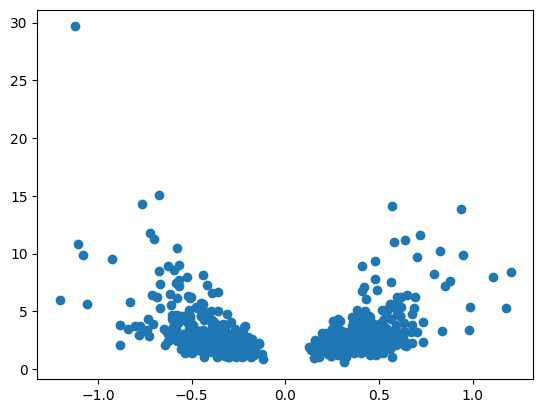

In [127]:
plt.scatter(eqtl['slope'], -np.log10(eqtl['pval_nominal']))

In [128]:
eqtl.sort_values('qval')

,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold
104,THEMIS2,543,1.043150,42.627647,58.769154,1.937586e-24,chr1_27894619_C_G,22076,22076,95,113,0.646875,2.175521e-30,-1.123607,0.058686,0.000100,9.038840e-24,3.916831e-21,0.000371
109,PHACTR4,513,1.042619,25.723085,58.558434,8.574653e-13,chr1_28364726_T_C,-4856,-4856,112,154,0.518750,8.547803e-16,-0.676434,0.066180,0.000100,7.614997e-12,1.649916e-09,0.000613
363,WARS2-AS1,387,0.999552,21.967860,61.340744,1.101074e-12,chr1_119177063_T_C,36672,36672,111,141,0.440625,5.186481e-15,-0.763788,0.077929,0.000100,2.445919e-11,3.532995e-09,0.000588
416,S100A11,350,1.041535,27.451088,58.134098,5.372389e-12,chr1_152035123_T_C,-12784,-12784,73,89,0.278125,6.900344e-15,0.568253,0.058374,0.000100,5.660559e-11,6.132272e-09,0.000571
542,COLGALT2,602,1.046780,61.626274,60.355000,3.506960e-12,chr1_183966219_A_G,-71510,-71510,123,158,0.493750,1.283292e-14,0.937430,0.097740,0.000100,7.478834e-11,6.481656e-09,0.000261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,CMPK1,618,1.056639,35.630245,57.697420,1.174397e-01,chr1_47338597_T_C,4800,4800,49,53,0.834375,7.594095e-02,0.243972,0.135542,0.985401,9.868227e-01,6.307126e-01,0.000470
30,PIK3CD,454,1.052367,60.061527,60.020172,6.694012e-02,chr1_9637301_GGGA_G,-14430,-14430,45,50,0.156250,4.176306e-02,-0.165058,0.079666,0.981102,9.825778e-01,6.307126e-01,0.000274
38,TARDBP,759,1.056247,85.504580,60.487090,5.016911e-02,chr1_10972158_T_C,-40186,-40186,43,50,0.156250,3.016664e-02,0.291757,0.131991,0.982502,9.861356e-01,6.307126e-01,0.000196
150,THRAP3,342,1.013887,28.574425,62.593887,1.627616e-01,chr1_36237033_A_G,12601,12601,65,71,0.778125,1.288545e-01,-0.121430,0.079067,0.993201,9.935559e-01,6.331484e-01,0.000484


In [19]:
# test PCA
from sklearn.decomposition import PCA
import numpy as np
X = np.random.rand(300,500)


In [20]:
X.shape

(300, 500)

In [21]:
epca30 = PCA(n_components=30)
epca30.fit(X)

PCA(n_components=30)

In [22]:
epca50 = PCA(n_components=50)
epca50.fit(X)

PCA(n_components=50)

In [25]:
epca50.components_.shape

(50, 500)

In [26]:
epca30.components_.shape

(30, 500)

In [28]:
np.corrcoef(epca50.components_[29,:], epca30.components_[29,:])

array([[1., 1.],
       [1., 1.]])

In [ ]:
eqtl_ctl = pd.read_csv("../../test/test123/eqtl_results/tensorqtl_results/tensorqtl_permute.Macrophages.CTL.csv")
eqtl_lps = pd.read_csv("../../test/test123/eqtl_results/tensorqtl_results/tensorqtl_permute.Macrophages.LPS.csv")
eqtl_ifn = pd.read_csv("../../test/test123/eqtl_results/tensorqtl_results/tensorqtl_permute.Macrophages.IFN.csv")